# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [2]:
# CodeWrite 
# Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def calculate_kernel(x, y, kernel, kernel_param):
    """
    Calculate the kernel between x and y
    """
    if kernel == 'linear':
        return np.dot(x, y)
    elif kernel == 'poly':
        return (1 + np.dot(x, y)) ** kernel_param
    elif kernel == 'rbf':
        return np.exp(-kernel_param * np.linalg.norm(x - y) ** 2)

def calculate_kernel_matrix(X, kernel, kernel_param):
    """
    Calculate the kernel matrix for the data X
    """
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = calculate_kernel(X[i], X[j], kernel, kernel_param)
    
    return K

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., kernel_param=1., num_iter_gd=100):
    """
    Arguments:
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = $\ lambda$
    num_iter_gd = number of GD iterations.

    Returns the result of kernel logistic regression :
    alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    Primal problem:
    $ \ min_w  \ sum_{i=1}^n \ log(1+\ exp(-y_i* \ w^\ top \phi(\ x_i)))  + \ frac{\ lambda}{2} ||\ w||^2 $

    the dual of which is

    $ \ min_alpha \ sum_{i=1}^n \ log(1+\ exp(-y_i* \ alpha^\ top K_{:,i} ))  + \ frac{\ lambda}{2} \ alpha^\ top K \ alpha $
    where $\ phi$ is the feature got by the kernel.

    Where K is the nxn kernel matrix computed on the training data.

    The kernel is defined by the kernel_param:
    If kernel=linear: K(\ u,\ v) = \ u^\ top \ v  
    If kernel=poly:  K(\ u,\ v) = (1+\ u^\ top \ v)^(kernel_param)
    If kernel=rbf:  K(\ u,\ v) = \ exp(-kernel_param*||\ u-\ v||^2)
    """
    kernel_X = calculate_kernel_matrix(X, kernel, kernel_param)
    alpha = np.zeros(X.shape[0])

    assert(kernel_X.shape[1] == alpha.shape[0])
    assert(kernel_X.shape[0] == X.shape[0])

    eta = 0.1
    
    for i in range(num_iter_gd):
        delta_R_alpha = np.zeros(alpha.shape[0])
        alpha[np.isnan(alpha)] = 0
        for j in range(X.shape[0]):
            kernel_term = kernel_X[:, j]
            exp_term = np.exp(Y[j] * np.dot(alpha, kernel_term))
            const = -Y[j] * (1 / (1 + exp_term))
            delta_R_alpha += const * kernel_term
        delta_R_alpha += reg_param * np.matmul(kernel_X, alpha)
        alpha = alpha - eta * delta_R_alpha
    
    return alpha

def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    pred = np.zeros(test_X.shape[0])
    for i in range(test_X.shape[0]):
        for j in range(train_X.shape[0]):
            pred[i] += alpha[j] * calculate_kernel(test_X[i], train_X[j], kernel, kernel_param)
        pred[i] = np.sign(pred[i])
    
    pred[np.isnan(pred)] = 1.0
    pred[pred == 0] = 1.0
    
    return pred

C:\Users\bersi\AppData\Local\Temp\ipykernel_19112\2887407598.py:68: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(Y[j] * np.dot(alpha, kernel_term))
C:\Users\bersi\AppData\Local\Temp\ipykernel_19112\2887407598.py:71: RuntimeWarning: overflow encountered in multiply
  delta_R_alpha += reg_param * np.matmul(kernel_X, alpha)
C:\Users\bersi\AppData\Local\Temp\ipykernel_19112\2887407598.py:83: RuntimeWarning: invalid value encountered in double_scalars
  pred[i] += alpha[j] * calculate_kernel(test_X[i], train_X[j], kernel, kernel_param)


Best kernel: linear, kernel_param: 1, reg_param: 0.0001, accuracy: 0.8958333333333334
Test accuracy: 0.86


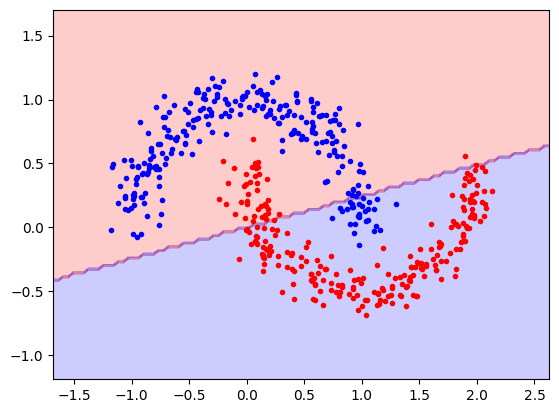

C:\Users\bersi\AppData\Local\Temp\ipykernel_19112\2887407598.py:71: RuntimeWarning: invalid value encountered in matmul
  delta_R_alpha += reg_param * np.matmul(kernel_X, alpha)
C:\Users\bersi\AppData\Local\Temp\ipykernel_19112\2887407598.py:71: RuntimeWarning: overflow encountered in matmul
  delta_R_alpha += reg_param * np.matmul(kernel_X, alpha)
C:\Users\bersi\AppData\Local\Temp\ipykernel_19112\2887407598.py:72: RuntimeWarning: invalid value encountered in subtract
  alpha = alpha - eta * delta_R_alpha


Best kernel: poly, kernel_param: 2, reg_param: 0.0001, accuracy: 0.8708333333333333
Test accuracy: 0.846


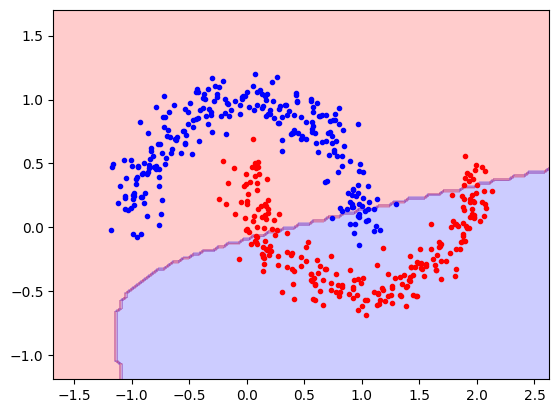

Best kernel: rbf, kernel_param: 1, reg_param: 0.0001, accuracy: 1.0
Test accuracy: 0.996


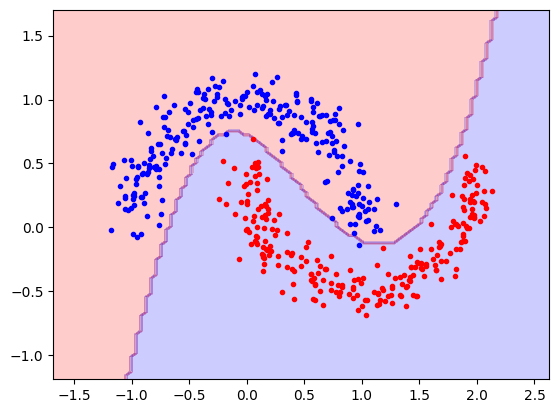

In [10]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

kernal_params = [1, 2, 4]
reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

data = np.load("../../Data/dataset_A.npz")
X_train = data['arr_0']
Y_train = data['arr_1']
X_test = data['arr_2']
Y_test = data['arr_3']

# 80 percent for train 
X_train = X_train[:int(0.8 * X_train.shape[0])]
Y_train = Y_train[:int(0.8 * Y_train.shape[0])]
# 20 percent for validation
X_val = X_train[int(0.8 * X_train.shape[0]):]
Y_val = Y_train[int(0.8 * Y_train.shape[0]):]

kernels = ['linear', 'poly', 'rbf']

def find_best_parameter(kernel):
    best_kernel_param = 0
    best_reg_param = 0
    best_accuracy = 0
    for kernel_param in kernal_params:
        for reg_param in reg_params:
            alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
            pred = test_pred(alpha, X_train, Y_train, X_val, kernel, kernel_param)
            accuracy = np.mean(pred == Y_val)
            # print("kernel: {}, kernel_param: {}, reg_param: {}, accuracy: {}".format(kernel, kernel_param, reg_param, accuracy))
            if accuracy > best_accuracy:
                best_kernel_param = kernel_param
                best_reg_param = reg_param
                best_accuracy = accuracy
    return best_kernel_param, best_reg_param, best_accuracy

def plot(alpha, X_test, Y_test, kernel, kernel_param):
    minX = np.min(X_test[:, 0])
    maxX = np.max(X_test[:, 0])
    minY = np.min(X_test[:, 1])
    maxY = np.max(X_test[:, 1])
    points = 100
    X, Y = np.meshgrid(np.linspace(minX - 0.5, maxX + 0.5, points), np.linspace(minY - 0.5, maxY + 0.5, points))
    Z = np.zeros((points, points))
    X_plotter = np.zeros((points * points, 2))
    for i in range(points):
        for j in range(points):
            X_plotter[i * points + j, 0] = X[i, j]
            X_plotter[i * points + j, 1] = Y[i, j]
    pred = test_pred(alpha, X_train, Y_train, X_plotter, kernel, kernel_param)
    Z = pred.reshape((points, points))
    plt.contourf(X, Y, Z, alpha=0.2, colors=['r', 'b'])
    plt.scatter(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1], marker='.', color='r')
    plt.scatter(X_test[Y_test == -1, 0], X_test[Y_test == -1, 1], marker='.', color='b')
    plt.show()

for kernel in kernels:
    best_kernel_param, best_reg_param, best_accuracy = find_best_parameter(kernel)
    print("Best kernel: {}, kernel_param: {}, reg_param: {}, accuracy: {}".format(kernel, best_kernel_param, best_reg_param, best_accuracy))

    alpha = train_pred_logistic_regression(X_train, Y_train, kernel, best_reg_param, best_kernel_param)
    pred = test_pred(alpha, X_train, Y_train, X_test, kernel, best_kernel_param)
    accuracy = np.mean(pred == Y_test)
    print("Test accuracy: {}".format(accuracy))
    plot(alpha, X_test, Y_test, kernel, best_kernel_param)


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  




In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6



# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [2]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

def train_svm(X, Y, kernel, reg_param, kernel_param):
    """
    Train SVM classifier using sklearn.svm.SVC
    """
    clf = svm.SVC(kernel=kernel, C=reg_param, coef0=1.0, degree=kernel_param, gamma=1.0)
    if kernel == 'rbf':
        clf.set_params(**{'gamma': kernel_param})
    clf.fit(X, Y)
    return clf

def predict_value(clf, X):
    """
    Predict using the SVM classifier
    """
    return clf.predict(X)


Best kernel: linear, kernel_param: 1, reg_param: 0.1, accuracy: 0.8958333333333334
Test accuracy: 0.866


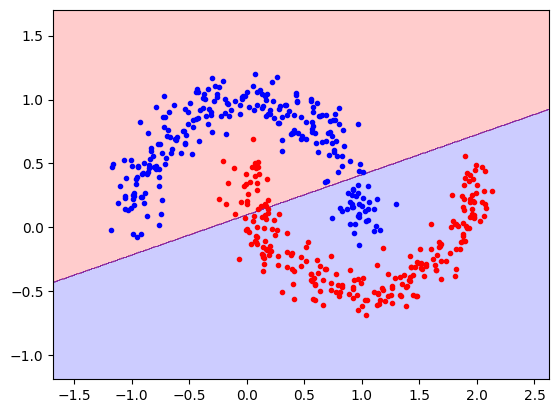

Best kernel: rbf, kernel_param: 1, reg_param: 1, accuracy: 1.0
Test accuracy: 0.998


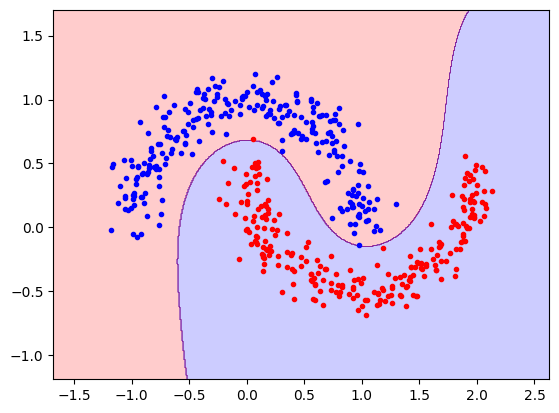

Best kernel: poly, kernel_param: 1, reg_param: 10, accuracy: 0.9625
Test accuracy: 0.92


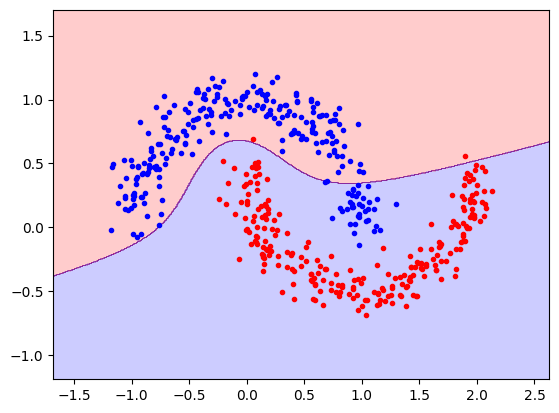

In [4]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.

kernal_params = [1, 2, 4]
reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]

data = np.load("../../Data/dataset_A.npz")
X_train = data['arr_0']
Y_train = data['arr_1']
X_test = data['arr_2']
Y_test = data['arr_3']

# 80 percent for train
X_train = X_train[:int(0.8 * X_train.shape[0])]
Y_train = Y_train[:int(0.8 * Y_train.shape[0])]
# 20 percent for validation
X_val = X_train[int(0.8 * X_train.shape[0]):]
Y_val = Y_train[int(0.8 * Y_train.shape[0]):]

kernels = ['linear', 'rbf', 'poly']
def find_best_parameter(kernel):
    best_kernel_param = 0
    best_reg_param = 0
    best_accuracy = 0
    for kernel_param in kernal_params:
        for reg_param in reg_params:
            clf = train_svm(X_train, Y_train, kernel, reg_param, kernel_param)
            pred = predict_value(clf, X_val)
            accuracy = np.mean(pred == Y_val)
            # print("kernel: {}, kernel_param: {}, reg_param: {}, accuracy: {}".format(kernel, kernel_param, reg_param, accuracy))
            if accuracy > best_accuracy:
                best_kernel_param = kernel_param
                best_reg_param = reg_param
                best_accuracy = accuracy
    return best_kernel_param, best_reg_param, best_accuracy

def plot(clf, X_test, Y_test):
    minX = np.min(X_test[:, 0])
    maxX = np.max(X_test[:, 0])
    minY = np.min(X_test[:, 1])
    maxY = np.max(X_test[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX - 0.5, maxX + 0.5, points), np.linspace(minY - 0.5, maxY + 0.5, points))
    Z = np.zeros((points, points))
    for i in range(points):
        for j in range(points):
            Z[i][j] = clf.predict(np.array([[X[i][j], Y[i][j]]]))
    plt.contourf(X, Y, Z, alpha=0.2, colors=['r', 'b'])
    plt.scatter(X_test[Y_test == 1, 0], X_test[Y_test == 1, 1], marker='.', color='r')
    plt.scatter(X_test[Y_test == -1, 0], X_test[Y_test == -1, 1], marker='.', color='b')
    plt.show()

for kernel in kernels:
    best_kernel_param, best_reg_param, best_accuracy = find_best_parameter(kernel)
    print("Best kernel: {}, kernel_param: {}, reg_param: {}, accuracy: {}".format(kernel, best_kernel_param, best_reg_param, best_accuracy))

    clf = train_svm(X_train, Y_train, kernel, best_reg_param, best_kernel_param)
    pred = predict_value(clf, X_test)
    accuracy = np.mean(pred == Y_test)
    print("Test accuracy: {}".format(accuracy))
    plot(clf, X_test, Y_test)


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  


In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6




# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [ ]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)
def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """





In [ ]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  



In [ ]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 




# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [ ]:
# CodeWrite cell
# Write Random Forest classifier. 
def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
    """ 
    Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    

def eval_random_forest(random_forest, test_X):
    """ 
    Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """




In [ ]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  


In [ ]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 


# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [ ]:
# Codewrite cell
# Write code to run here (no plotting)


In [ ]:
# Codewrite cell 
# Plots for iteration vs error here


In [ ]:
# Codewrite cell 
# Plots for illustrating the classifier here


Textwrite cell: